# What do I want?

Previously in `../catalog_only_classifier/classifier_comparison.ipynb` I got a Random Forest-predicted probability of each galaxy being a low-z dwarf. Now I want to select a subset of the galaxies most likely to be dwarfs, and pull their images from the HSC servers.

# Code
First let's load some general information about each galaxy, in case we want to see how our "dwarf galaxy scores" correlate with various properties

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd
import glob
import shutil

from scipy.special import expit

In [2]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [3]:
HSC_filename = os.path.join(dwarfz.data_dir_default, "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [4]:
matches_filename = os.path.join(dwarfz.data_dir_default, "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [5]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [6]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [7]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

## Get FRANKENZ photo-z's


In [8]:
df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    os.path.join(dwarfz.data_dir_default,
                                                 "HSC_matched_to_FRANKENZ.sqlite")),
                                index_col="object_id")

df_frankenz.head()

,FRANKENZ_ids,photoz_best,photoz_risk_best
object_id,,,
43158034708430853,43158034708462402,3.39,0.410430
43158034708430859,43158034708462728,2.68,0.186912
43158034708430861,43158034708462729,2.57,0.565077
43158034708430866,43158034708438547,1.59,0.466111
43158034708430870,43158034708438694,2.37,0.363387


In [9]:
combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

# Create classification labels

In [10]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass > 8) & (combined.log_mass < 9)

In [11]:
combined["low_z_low_mass"] = (low_z & low_mass)
combined.low_z_low_mass.mean()

0.0021850729760273151

# Load scores for each galaxy
This scores were created within `catalog_only_classifier/classifier_ROC_curves.ipynb`. These scores are also non-deterministic -- getting a new realization will lead to slightly different results (but hopefully with no dramatic changes).

In [13]:
filename = "galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv"

In [14]:
!head -n 20 $filename

COSMOS_id,HSC_id,dwarf_prob,low_z_low_mass
628457,43158322471244656,0.0,False
919771,43158605939114836,0.0,False
444239,43159142810013665,0.0,False
569427,43158734788125011,0.06333333333333334,False
369948,43158863637144621,0.6066666666666667,True
774881,43158464205193248,0.0,False
284143,43158309586361270,0.0,False
910106,43158468500160065,0.0,False
988664,43158747673006735,0.0,False
718450,43159151399949013,0.0,False
856273,43158193622240311,0.0,False
627429,43158322471244576,0.0,False
807370,43158468500150416,0.0,False
746672,43158464205165131,0.0,False
901924,43159018255969735,0.0,False
902781,43158468500159652,0.0,False
845231,43158743378044104,0.0,False
323432,43158588759212951,0.0,False
256187,43158584464272098,0.0,False


In [15]:
df_dwarf_prob = pd.read_csv(filename)
df_dwarf_prob.head()

,COSMOS_id,HSC_id,dwarf_prob,low_z_low_mass
0,628457,43158322471244656,0.000000,False
1,919771,43158605939114836,0.000000,False
2,444239,43159142810013665,0.000000,False
3,569427,43158734788125011,0.063333,False
4,369948,43158863637144621,0.606667,True


In [16]:
theoretical_probs=np.linspace(0,1,num=20+1)

In [17]:
empirical_probs_RF = np.empty(theoretical_probs.size-1)

In [18]:
for i in range(theoretical_probs.size-1):
    prob_lim_low  = theoretical_probs[i]
    prob_lim_high = theoretical_probs[i+1]
    
    mask_RF = (df_dwarf_prob.dwarf_prob >= prob_lim_low) & (df_dwarf_prob.dwarf_prob < prob_lim_high)
    empirical_probs_RF[i] = df_dwarf_prob.low_z_low_mass[mask_RF].mean()

/Users/egentry/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


(0, 1)

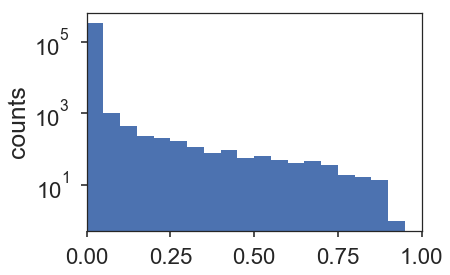

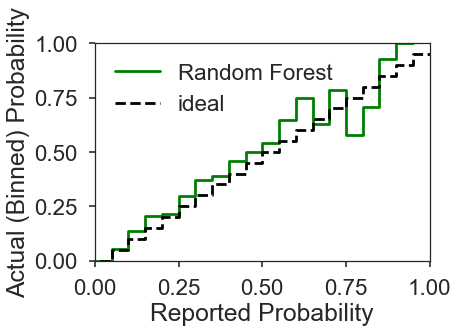

In [19]:
color_RF = "g"
label_RF = "Random Forest"

plt.hist(df_dwarf_prob.dwarf_prob, bins=theoretical_probs)
plt.xlim(0,1)
plt.yscale("log")
plt.ylabel("counts")

plt.figure()


plt.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
         linestyle="steps", color=color_RF, label=label_RF)

plt.plot(theoretical_probs, theoretical_probs-.05, 
         drawstyle="steps", color="black", label="ideal", linestyle="dashed")

plt.xlabel("Reported Probability")
plt.ylabel("Actual (Binned) Probability")

plt.legend(loc="best")

plt.xlim(0,1)
plt.ylim(0,1)


## select the best 1000 / sq.deg.

In [21]:
COSMOS_field_area = 2 # sq. deg.

In [22]:
sample_size = int(1000 * COSMOS_field_area)
print("sample size: ", sample_size)

sample size:  2000


In [23]:
selected_galaxies = df_dwarf_prob.sort_values("dwarf_prob", ascending=False)[:sample_size]
print("threshold: ", selected_galaxies.dwarf_prob.min())
print("galaxies at or above threshold: ", (df_dwarf_prob.dwarf_prob>=selected_galaxies.dwarf_prob.min()).sum() )

threshold:  0.0766666666667
galaxies at or above threshold:  2034


In [24]:
df_dwarf_prob.dwarf_prob.min()

0.0

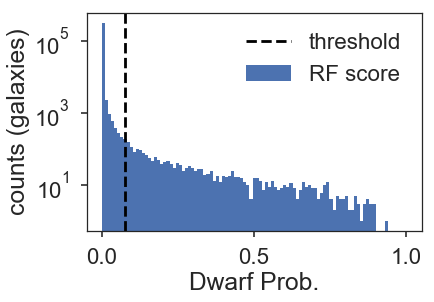

In [25]:
bins = np.linspace(0,1, num=100)

plt.hist(df_dwarf_prob.dwarf_prob, bins=bins, label="RF score")

plt.axvline(selected_galaxies.dwarf_prob.min(), linestyle="dashed", color="black", label="threshold")

plt.legend(loc="best")

plt.xlabel("Dwarf Prob.")
plt.ylabel("counts (galaxies)")
plt.yscale("log")

In [26]:
# how balanced is the CNN training set? What fraction are actually dwarfs?
selected_galaxies.low_z_low_mass.mean()

0.27750000000000002

# Get the images from the quarry

For technical details, see: https://hsc-release.mtk.nao.ac.jp/das_quarry/manual.html

## Create a coordinates list

In [27]:
selected_galaxy_coords = HSC.df.loc[selected_galaxies.HSC_id][["ra", "dec"]]
selected_galaxy_coords.head()

,ra,dec
object_id,,
43158867932114914,149.796491,2.068317
43159005371060865,149.732554,1.952818
43158447025318464,150.464235,1.740864
43158318176298953,150.653618,2.066278
43158322471241683,150.685796,2.183352


In [122]:
selected_galaxy_coords.to_csv("galaxy_images_training/2017_09_26-selected_galaxy_coords.csv")

In [29]:
width = "20asec"
filters = ["HSC-G", "HSC-R", "HSC-I", "HSC-Z", "HSC-Y"]
rerun = "pdr1_deep"

In [49]:
tmp_filename = "galaxy_images_training/tmp_quarry.txt"
tmp_filename_missing_ext = tmp_filename[:-3]

with open(tmp_filename, mode="w") as f:

#     print("#?     ra          dec       filter   sw      sh      rerun", file=f)

    print_formatter = " {galaxy.ra:.6f}deg  {galaxy.dec:.6f}deg  {filter}  {width}  {width}  {rerun}"
    for galaxy in selected_galaxy_coords.itertuples():

        for filter in filters:
            print(print_formatter.format(galaxy=galaxy,
                                         width=width,
                                         filter=filter,
                                         rerun=rerun),
                  file=f)

In [51]:
!head -n 10 $tmp_filename

 149.796491deg  2.068317deg  HSC-G  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-R  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-I  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-Z  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-Y  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-G  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-R  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-I  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-Z  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-Y  20asec  20asec  pdr1_deep


In [52]:
!wc -l $tmp_filename

   10000 galaxy_images_training/tmp_quarry.txt


In [53]:
!split -a 1 -l 1000 $tmp_filename $tmp_filename_missing_ext

To do: I need to find a way to deal with the script below when there aren't any files to process (i.e. they've already been processeded)

In [72]:
for filename_old in sorted(glob.glob("galaxy_images_training/tmp_quarry.?")):
    filename_new =  filename_old + ".txt"
    
    with open(filename_new, mode="w") as f_new:
        f_new.write("#?     ra           dec      filter   sw      sh      rerun\n")

        with open(filename_old, mode="r") as f_old:
            data = f_old.read()
        f_new.write(data)
        
    os.remove(filename_old)

In [74]:
!ls galaxy_images_training/

2017_09_26-coords.csv              tmp_quarry.f.txt
2017_09_26-dwarf_galaxy_scores.csv tmp_quarry.g.txt
tmp_quarry.a.txt                   tmp_quarry.h.txt
tmp_quarry.b.txt                   tmp_quarry.i.txt
tmp_quarry.c.txt                   tmp_quarry.j.txt
tmp_quarry.d.txt                   tmp_quarry.txt
tmp_quarry.e.txt


###  Make the request via curl

1)

First you need to setup you authentication information. Add it to a file like `galaxy_images_training/curl_netrc` which should look like:
```machine hsc-release.mtk.nao.ac.jp login <your username> password <your password>```
This allows you to script the curl calls, without being prompted for your password each time

2a) 

The `curl` call (in (2b)) will spit out files into a somewhat unpredicatably named directory, like `arch-170928-231223`. You should rename this to match the batch suffix. You *really should* do this right away, so you don't get confused. In general I add the rename onto the same line as the curl call:
``` curl ... | tar xvf - && mv arch-* quarry_files_a     ```

This only works if it finds one `arch-` directory, but you *really* shouldn't have multiple arch directories at any given time; that's a recipe for getting your galaxies mixed up.

2b) 

Here's the actual curl invocation:

``` curl --netrc-file galaxy_images_training/curl_netrc https://hsc-release.mtk.nao.ac.jp/das_quarry/cgi-bin/quarryImage --form list=@<coord list filename> | tar xvf -     ```



In [82]:
!head -n 10 galaxy_images_training/tmp_quarry.a.txt

#?     ra           dec      filter   sw      sh      rerun
 149.796491deg  2.068317deg  HSC-G  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-R  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-I  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-Z  20asec  20asec  pdr1_deep
 149.796491deg  2.068317deg  HSC-Y  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-G  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-R  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-I  20asec  20asec  pdr1_deep
 149.732554deg  1.952818deg  HSC-Z  20asec  20asec  pdr1_deep


In [92]:
!ls -lhtr galaxy_images_training/quarry_files_a | head -n 11

total 478080
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 2-cutout-HSC-G-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 3-cutout-HSC-R-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 4-cutout-HSC-I-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 5-cutout-HSC-Z-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 6-cutout-HSC-Y-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 7-cutout-HSC-G-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 8-cutout-HSC-R-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 9-cutout-HSC-I-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 10-cutout-HSC-Z-9813-pdr1_deep.fits
-rw-r--r--@ 1 egentry  staff   236K Sep 28 10:09 11-cutout-HSC-Y-9813-pdr1_deep.fits


# rename files with HSC-id
steps:

1) figure out what suffix we're using (e.g. `"a"`)

2) convert suffix into zero-indexed integer (e.g. `0`)

3) determine which HSC-ids corresponded to that file
  - e.g. from `suffix_int*200` to `(suffix_int+1)*200`
    
4) swapping the line number prefix with an HSC_id prefix, while preserving the rest of the filename (esp. the band information)


### make target directory
This'll hold the renamed files for *all* the batches

In [93]:
!mkdir -p galaxy_images_training/quarry_files

### set prefix

In [96]:
prefix_map = { char:i for i, char in enumerate(["a","b","c","d","e",
                                                "f","g","h","i","j"])
}

In [97]:
prefix = "a"
prefix_int = prefix_map[prefix]

print(prefix_int)

0


### find which files are missing
What should I do about these incomplete files? idk, I guess just throw them out for now.

In [109]:
files = glob.glob("galaxy_images_training/quarry_files_{prefix}/*".format(prefix=prefix))
file_numbers = [int(os.path.basename(file).split("-")[0]) for file in files]
file_numbers = np.array(sorted(file_numbers))

In [113]:
desired_range = np.arange(2,1002)
print("missing file numbers: ", desired_range[~np.isin(desired_range, file_numbers)])

missing file numbers:  [602 603 827 828]


### get HSC ids for index

In [114]:
i_start = prefix_int*200
i_end = (prefix_int+1)*200
print(i_start, i_end)
HSC_ids_for_prefix = selected_galaxies.iloc[i_start:i_end].HSC_id.values

0 200


In [115]:
HSC_ids_for_prefix

array([43158867932114914, 43159005371060865, 43158447025318464,
       43158318176298953, 43158322471241683, 43159134220067726,
       43158743378067391, 43159147104979540, 43159018255944554,
       43158876522051604, 43158605939114353, 43158863637144619,
       43158468500160019, 43158743378064543, 43159138515050818,
       43158588759241814, 43158605939111439, 43158593054203646,
       43158726198193805, 43158331061198463, 43158447025317690,
       43158867932109423, 43158331061199021, 43159001076075627,
       43158863637141906, 43158455615252247, 43159018255970241,
       43158468500151314, 43158743378061516, 43159022550928968,
       43158996781127885, 43158885111981225, 43158468500157242,
       43159001076101324, 43158743378042636, 43158588759240069,
       43158322471244647, 43159138515047809, 43159009666030738,
       43158743378060916, 43158863637119173, 43158863637140239,
       43158730493155839, 43158859342177262, 43158593054202740,
       43158584464276697, 43158863637143

In [117]:
i_file = 1
for HSC_id in HSC_ids_for_prefix:
    for filter in filters:
        i_file += 1

        filenames = glob.glob("galaxy_images_training/quarry_files_{prefix}/{i_file}-*-{filter}-*.fits".format(
            prefix=prefix,
            i_file=i_file, 
            filter=filter))
        if len(filenames) > 1:
            raise ValueError("too many matching files for i_file={}".format(i_file))
        elif len(filenames) == 0:
            print("skipping missing i_file={}".format(i_file))
            continue
            
        old_filename = filenames[0]
        new_filename = old_filename.replace("/{i_file}-".format(i_file=i_file),
                                            "/{HSC_id}-".format(HSC_id=HSC_id))
        new_filename = new_filename.replace("quarry_files_{prefix}".format(prefix=prefix),
                                            "quarry_files")
        
        if os.path.exists(old_filename):
            # for now use a copy operation, so I can fix things if it breaks, 
            # but later this should be a move instead
            
            os.rename(old_filename, new_filename)
        

skipping missing i_file=602
skipping missing i_file=603
skipping missing i_file=827
skipping missing i_file=828


# clean up old files

In [121]:
for file in glob.glob("galaxy_images_training/tmp_quarry.?.txt"):
    os.remove(file)

In [123]:
for file in glob.glob("galaxy_images_training/quarry_files_?"):
    # will fail if the directory isn't empty
    # (directory should be empty after moving the renamed files to `quarry_files`)
    os.rmdir(file)

In [124]:
filename = "galaxy_images_training/tmp_quarry.txt"
if os.path.exists(filename):
    os.remove(filename)